In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import pandas as pd
import numpy as np
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.mixed_effects import MixedEffects
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

fpath = glob.glob(os.path.join(data.data_path, "rats_data/amap*/*/*.csv"))
df = None

for f in fpath:
    temp = pd.read_csv(f)

    participant = f.split("/")[-3]
    temp["participant"] = participant

    temp = temp[temp.channel1_segment.isna()].copy()

    temp["method"] = temp.channel2_laterality

    if df is None:
        df = temp.copy()
    else:
        df = pd.concat([df, temp], ignore_index=True).copy()

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)

df = df[df.participant.isin([0])].copy()
df = df[df.compound_position.isin([0, 1])].copy()
df.reset_index(drop=True, inplace=True)

2023-05-23 10:29:03,754 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-23 10:29:03,806 - hb_mep.utils.utils - INFO - func:preprocess took: 0.05 sec
2023-05-23 10:29:03,806 - hb_mep.utils.utils - INFO - func:build took: 0.05 sec


#### Plot

2023-05-23 10:29:03,912 - hb_mep.utils.utils - INFO - func:plot took: 0.05 sec


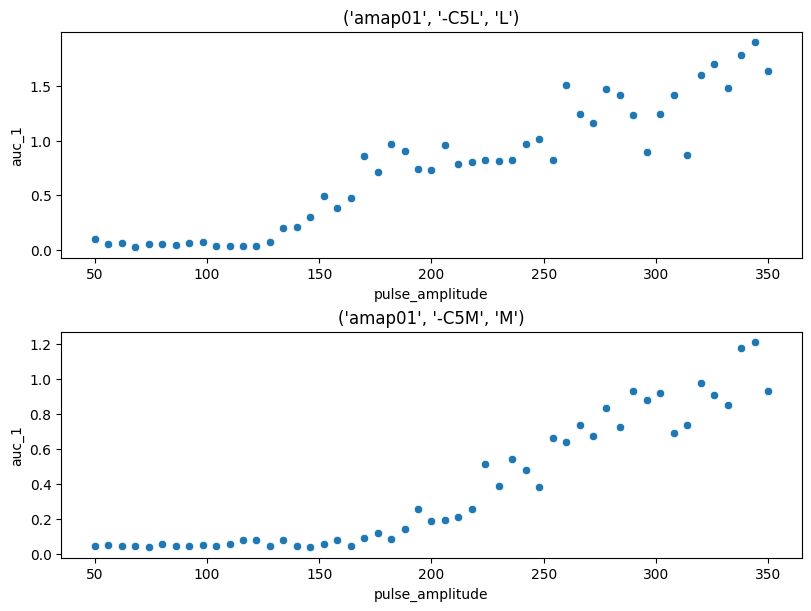

In [5]:
plot(df=df, encoder_dict=encoder_dict);

#### Initialize model

In [6]:
model = MixedEffects(config)

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-23 10:29:04,326 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-23 10:29:04,327 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:29:04,327 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:29:04,328 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-23 10:29:04,328 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-23 10:29:04,362 - hb_mep.models.rats.mixed_effects - INFO - Running inference with Mixed_Ef

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-23 10:29:35,034 - hb_mep.utils.utils - INFO - func:run_inference took: 30.71 sec


#### Diagnostics

In [8]:
mcmc.print_summary(prob=.95)


                           mean       std    median      2.5%     97.5%     n_eff     r_hat
             b[0,0,0]      0.01      0.00      0.01      0.01      0.01   1075.49      1.01
             b[0,1,0]      0.02      0.03      0.01      0.00      0.07   7445.95      1.00
             b[1,0,0]      0.02      0.03      0.01      0.00      0.07   4925.35      1.00
             b[1,1,0]      0.01      0.00      0.01      0.01      0.01  10245.67      1.00
           b_scale[0]      0.02      0.02      0.01      0.00      0.07   5715.55      1.00
        baseline[0,0]    120.15      5.35    121.34    109.02    128.47   1086.61      1.01
        baseline[1,0]    122.90     25.21    121.85     74.22    177.09    206.03      1.02
     baseline_mean[0]    123.35     16.81    121.88     90.40    161.54   4285.67      1.00
    baseline_scale[0]     15.16     11.25     13.24      0.34     37.06   4791.40      1.00
           delta[0,0]     42.47     37.66     44.21    -40.88    112.69    492.

#### Plot fitted curves

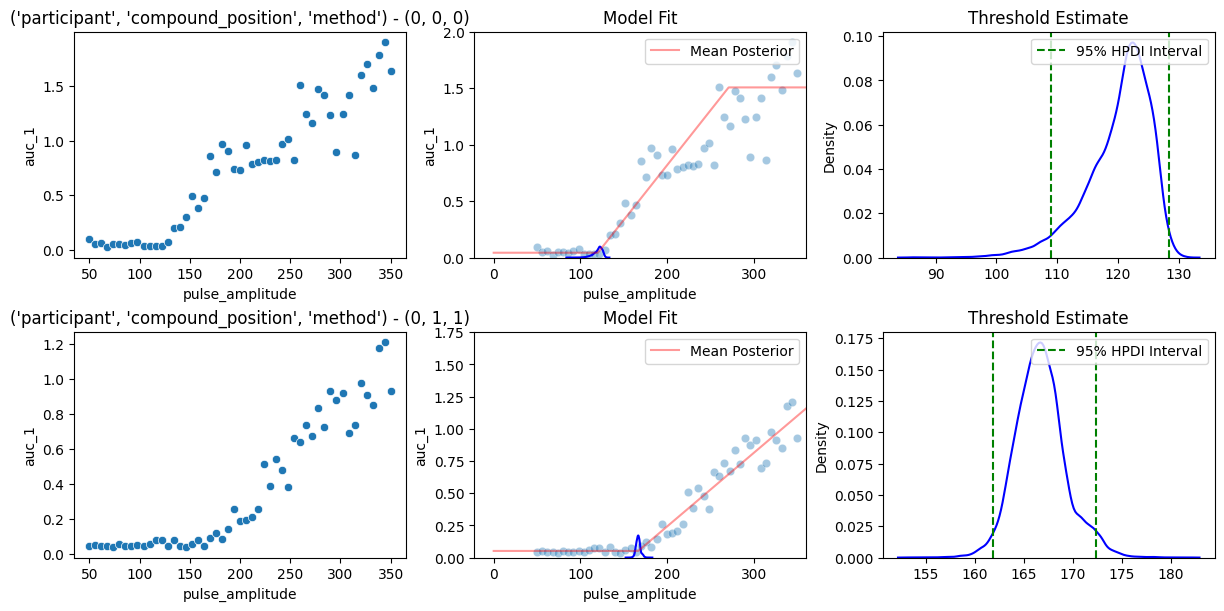

In [9]:
model.plot(df=df, posterior_samples=posterior_samples);

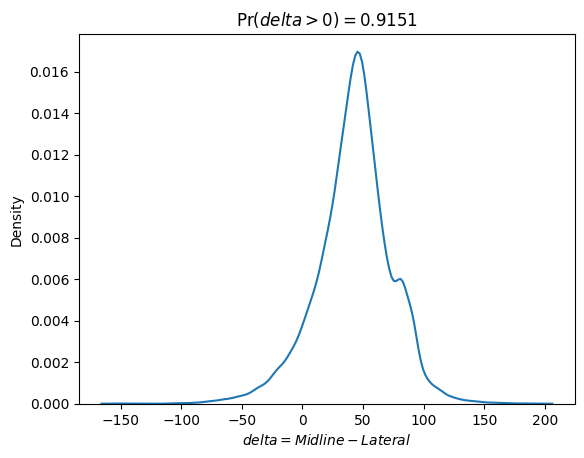

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

samples = posterior_samples["delta_mean"]
pr = (samples > 0).mean()

sns.kdeplot(samples)
plt.title(f"$\Pr (delta > 0) = {pr : .04}$")
plt.xlabel(f"$delta = Midline - Lateral$");